In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_4_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[4].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:08<00:00,  3.38it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:06<00:00, 37.38it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:26<00:00,  2.81it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:08<00:00, 29.31it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 9/2000 [00:08<30:20,  1.09it/s]

Epoch 10/2000, Loss: 0.6424
Test Accuracy at Epoch 10: 62.11%
Test F1-score at Epoch 10: 0.6682
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.69      0.47      0.56       194
non_infringement       0.58      0.78      0.67       186

        accuracy                           0.62       380
       macro avg       0.64      0.62      0.61       380
    weighted avg       0.64      0.62      0.61       380



Training Epochs:   0%|          | 10/2000 [00:09<32:01,  1.04it/s]

New best model saved with F1-score 0.6682 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.69      0.47      0.56       194
non_infringement       0.58      0.78      0.67       186

        accuracy                           0.62       380
       macro avg       0.64      0.62      0.61       380
    weighted avg       0.64      0.62      0.61       380



Training Epochs:   1%|          | 19/2000 [00:16<23:59,  1.38it/s]

Epoch 20/2000, Loss: 0.5508


Training Epochs:   1%|          | 20/2000 [00:17<28:36,  1.15it/s]

Test Accuracy at Epoch 20: 69.47%
Test F1-score at Epoch 20: 0.7225
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380

New best model saved with F1-score 0.7225 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   2%|▏         | 30/2000 [00:24<25:36,  1.28it/s]

Epoch 30/2000, Loss: 0.4651
Test Accuracy at Epoch 30: 69.47%
Test F1-score at Epoch 30: 0.7573
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.94      0.43      0.59       194
non_infringement       0.62      0.97      0.76       186

        accuracy                           0.69       380
       macro avg       0.78      0.70      0.67       380
    weighted avg       0.78      0.69      0.67       380

New best model saved with F1-score 0.7573 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.94      0.43      0.59       194
non_infringement       0.62      0.97      0.76       186

        accuracy                           0.69       380
       macro avg       0.78      0.70      0.67       380
    weighted avg       0.78      0.69      0.67       380



Training Epochs:   2%|▏         | 40/2000 [00:30<20:21,  1.60it/s]

Epoch 40/2000, Loss: 0.3828
Test Accuracy at Epoch 40: 72.63%
Test F1-score at Epoch 40: 0.7709
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.90      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380

New best model saved with F1-score 0.7709 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.90      0.52      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:   2%|▏         | 49/2000 [00:37<27:24,  1.19it/s]

Epoch 50/2000, Loss: 0.3545


Training Epochs:   2%|▎         | 50/2000 [00:38<30:33,  1.06it/s]

Test Accuracy at Epoch 50: 77.37%
Test F1-score at Epoch 50: 0.8045
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.93      0.60      0.73       194
non_infringement       0.70      0.95      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.82      0.77      0.77       380

New best model saved with F1-score 0.8045 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.93      0.60      0.73       194
non_infringement       0.70      0.95      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.82      0.77      0.77       380



Training Epochs:   3%|▎         | 59/2000 [00:46<28:46,  1.12it/s]

Epoch 60/2000, Loss: 0.3123


Training Epochs:   3%|▎         | 60/2000 [00:47<31:03,  1.04it/s]

Test Accuracy at Epoch 60: 78.95%
Test F1-score at Epoch 60: 0.8104
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380

New best model saved with F1-score 0.8104 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:   4%|▎         | 70/2000 [00:55<30:58,  1.04it/s]

Epoch 70/2000, Loss: 0.3029
Test Accuracy at Epoch 70: 79.74%
Test F1-score at Epoch 70: 0.8099
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   4%|▍         | 79/2000 [01:03<26:20,  1.22it/s]

Epoch 80/2000, Loss: 0.2707
Test Accuracy at Epoch 80: 80.00%
Test F1-score at Epoch 80: 0.8182
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:   4%|▍         | 80/2000 [01:04<27:03,  1.18it/s]

New best model saved with F1-score 0.8182 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:   4%|▍         | 90/2000 [01:12<27:21,  1.16it/s]

Epoch 90/2000, Loss: 0.2675
Test Accuracy at Epoch 90: 79.74%
Test F1-score at Epoch 90: 0.8205
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.80      0.79       380

New best model saved with F1-score 0.8205 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.80      0.79       380



Training Epochs:   5%|▍         | 99/2000 [01:19<24:20,  1.30it/s]

Epoch 100/2000, Loss: 0.2572
Test Accuracy at Epoch 100: 79.47%
Test F1-score at Epoch 100: 0.8178


Training Epochs:   5%|▌         | 100/2000 [01:20<25:51,  1.22it/s]

Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   6%|▌         | 110/2000 [01:28<26:16,  1.20it/s]

Epoch 110/2000, Loss: 0.2234
Test Accuracy at Epoch 110: 79.74%
Test F1-score at Epoch 110: 0.8080
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.79       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   6%|▌         | 119/2000 [01:35<25:56,  1.21it/s]

Epoch 120/2000, Loss: 0.2167
Test Accuracy at Epoch 120: 80.26%
Test F1-score at Epoch 120: 0.8157


Training Epochs:   6%|▌         | 120/2000 [01:36<28:36,  1.10it/s]

Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.87      0.72      0.79       194
non_infringement       0.75      0.89      0.82       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   6%|▋         | 130/2000 [01:44<23:20,  1.34it/s]

Epoch 130/2000, Loss: 0.1973
Test Accuracy at Epoch 130: 81.05%
Test F1-score at Epoch 130: 0.8182
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.86      0.75      0.80       194
non_infringement       0.77      0.87      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:   7%|▋         | 139/2000 [01:50<20:56,  1.48it/s]

Epoch 140/2000, Loss: 0.1954
Test Accuracy at Epoch 140: 78.42%
Test F1-score at Epoch 140: 0.8111


Training Epochs:   7%|▋         | 140/2000 [01:51<25:04,  1.24it/s]

Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   7%|▋         | 149/2000 [01:58<26:22,  1.17it/s]

Epoch 150/2000, Loss: 0.1820


Training Epochs:   8%|▊         | 150/2000 [02:00<28:49,  1.07it/s]

Test Accuracy at Epoch 150: 80.53%
Test F1-score at Epoch 150: 0.8177
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.88      0.72      0.79       194
non_infringement       0.75      0.89      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:   8%|▊         | 159/2000 [02:07<26:25,  1.16it/s]

Epoch 160/2000, Loss: 0.1791
Test Accuracy at Epoch 160: 80.26%
Test F1-score at Epoch 160: 0.8244
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:   8%|▊         | 160/2000 [02:09<35:19,  1.15s/it]

New best model saved with F1-score 0.8244 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:   8%|▊         | 169/2000 [02:17<27:50,  1.10it/s]

Epoch 170/2000, Loss: 0.1878
Test Accuracy at Epoch 170: 82.11%
Test F1-score at Epoch 170: 0.8265
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.86      0.77      0.82       194
non_infringement       0.79      0.87      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:   8%|▊         | 170/2000 [02:19<38:50,  1.27s/it]

New best model saved with F1-score 0.8265 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.86      0.77      0.82       194
non_infringement       0.79      0.87      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:   9%|▉         | 179/2000 [02:27<27:11,  1.12it/s]

Epoch 180/2000, Loss: 0.1711


Training Epochs:   9%|▉         | 180/2000 [02:28<28:32,  1.06it/s]

Test Accuracy at Epoch 180: 79.47%
Test F1-score at Epoch 180: 0.8211
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  10%|▉         | 190/2000 [02:36<24:55,  1.21it/s]

Epoch 190/2000, Loss: 0.1551
Test Accuracy at Epoch 190: 81.32%
Test F1-score at Epoch 190: 0.8238
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.88      0.74      0.80       194
non_infringement       0.76      0.89      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  10%|█         | 200/2000 [02:44<23:36,  1.27it/s]

Epoch 200/2000, Loss: 0.1479
Test Accuracy at Epoch 200: 81.05%
Test F1-score at Epoch 200: 0.8227
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.88      0.73      0.80       194
non_infringement       0.76      0.90      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  10%|█         | 209/2000 [02:50<19:43,  1.51it/s]

Epoch 210/2000, Loss: 0.2067
Test Accuracy at Epoch 210: 80.26%
Test F1-score at Epoch 210: 0.8260


Training Epochs:  10%|█         | 210/2000 [02:51<21:55,  1.36it/s]

Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.94      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.80      0.80       380



Training Epochs:  11%|█         | 219/2000 [02:59<25:20,  1.17it/s]

Epoch 220/2000, Loss: 0.1633
Test Accuracy at Epoch 220: 83.42%
Test F1-score at Epoch 220: 0.8475
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  11%|█         | 220/2000 [03:02<47:33,  1.60s/it]

New best model saved with F1-score 0.8475 at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  12%|█▏        | 230/2000 [03:11<25:52,  1.14it/s]

Epoch 230/2000, Loss: 0.1422
Test Accuracy at Epoch 230: 81.58%
Test F1-score at Epoch 230: 0.8341
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.93      0.69      0.79       194
non_infringement       0.75      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  12%|█▏        | 240/2000 [03:19<25:05,  1.17it/s]

Epoch 240/2000, Loss: 0.1322
Test Accuracy at Epoch 240: 79.47%
Test F1-score at Epoch 240: 0.8178
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  12%|█▎        | 250/2000 [03:27<26:44,  1.09it/s]

Epoch 250/2000, Loss: 0.1264
Test Accuracy at Epoch 250: 80.26%
Test F1-score at Epoch 250: 0.8260
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.94      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.80      0.80       380



Training Epochs:  13%|█▎        | 260/2000 [03:36<27:04,  1.07it/s]

Epoch 260/2000, Loss: 0.1219
Test Accuracy at Epoch 260: 80.26%
Test F1-score at Epoch 260: 0.8260
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.94      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.80      0.80       380



Training Epochs:  14%|█▎        | 270/2000 [03:45<27:30,  1.05it/s]

Epoch 270/2000, Loss: 0.1959
Test Accuracy at Epoch 270: 77.63%
Test F1-score at Epoch 270: 0.8107
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.97      0.58      0.73       194
non_infringement       0.69      0.98      0.81       186

        accuracy                           0.78       380
       macro avg       0.83      0.78      0.77       380
    weighted avg       0.83      0.78      0.77       380



Training Epochs:  14%|█▍        | 279/2000 [03:52<20:46,  1.38it/s]

Epoch 280/2000, Loss: 0.1283


Training Epochs:  14%|█▍        | 280/2000 [03:53<24:39,  1.16it/s]

Test Accuracy at Epoch 280: 80.79%
Test F1-score at Epoch 280: 0.8215
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.89      0.72      0.79       194
non_infringement       0.75      0.90      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  14%|█▍        | 290/2000 [04:01<20:57,  1.36it/s]

Epoch 290/2000, Loss: 0.1169
Test Accuracy at Epoch 290: 81.05%
Test F1-score at Epoch 290: 0.8252
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.79       194
non_infringement       0.75      0.91      0.83       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  15%|█▌        | 300/2000 [04:08<23:22,  1.21it/s]

Epoch 300/2000, Loss: 0.1156
Test Accuracy at Epoch 300: 79.47%
Test F1-score at Epoch 300: 0.8178
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  15%|█▌        | 309/2000 [04:16<23:55,  1.18it/s]

Epoch 310/2000, Loss: 0.1109


Training Epochs:  16%|█▌        | 310/2000 [04:17<25:21,  1.11it/s]

Test Accuracy at Epoch 310: 81.84%
Test F1-score at Epoch 310: 0.8353
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  16%|█▌        | 319/2000 [04:24<22:30,  1.24it/s]

Epoch 320/2000, Loss: 0.1071


Training Epochs:  16%|█▌        | 320/2000 [04:25<25:37,  1.09it/s]

Test Accuracy at Epoch 320: 80.26%
Test F1-score at Epoch 320: 0.8235
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.92      0.67      0.78       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  16%|█▋        | 330/2000 [04:35<28:18,  1.02s/it]

Epoch 330/2000, Loss: 0.1055
Test Accuracy at Epoch 330: 81.84%
Test F1-score at Epoch 330: 0.8353
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  17%|█▋        | 339/2000 [04:43<25:10,  1.10it/s]

Epoch 340/2000, Loss: 0.1044


Training Epochs:  17%|█▋        | 340/2000 [04:44<27:31,  1.00it/s]

Test Accuracy at Epoch 340: 79.74%
Test F1-score at Epoch 340: 0.8222
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.94      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.80      0.79       380



Training Epochs:  18%|█▊        | 350/2000 [04:53<26:42,  1.03it/s]

Epoch 350/2000, Loss: 0.1107
Test Accuracy at Epoch 350: 80.53%
Test F1-score at Epoch 350: 0.8279
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.94      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  18%|█▊        | 359/2000 [05:01<24:59,  1.09it/s]

Epoch 360/2000, Loss: 0.1044


Training Epochs:  18%|█▊        | 360/2000 [05:03<28:53,  1.06s/it]

Test Accuracy at Epoch 360: 81.84%
Test F1-score at Epoch 360: 0.8361
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  18%|█▊        | 369/2000 [05:09<16:58,  1.60it/s]

Epoch 370/2000, Loss: 0.0998


Training Epochs:  18%|█▊        | 370/2000 [05:10<19:17,  1.41it/s]

Test Accuracy at Epoch 370: 81.84%
Test F1-score at Epoch 370: 0.8361
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  19%|█▉        | 379/2000 [05:17<22:34,  1.20it/s]

Epoch 380/2000, Loss: 0.0975
Test Accuracy at Epoch 380: 81.84%
Test F1-score at Epoch 380: 0.8361
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  20%|█▉        | 390/2000 [05:26<22:07,  1.21it/s]

Epoch 390/2000, Loss: 0.1855
Test Accuracy at Epoch 390: 79.21%
Test F1-score at Epoch 390: 0.8192
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  20%|█▉        | 399/2000 [05:33<21:18,  1.25it/s]

Epoch 400/2000, Loss: 0.1234


Training Epochs:  20%|██        | 400/2000 [05:34<23:06,  1.15it/s]

Test Accuracy at Epoch 400: 80.53%
Test F1-score at Epoch 400: 0.8186
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.88      0.72      0.79       194
non_infringement       0.75      0.90      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  20%|██        | 409/2000 [05:42<22:33,  1.18it/s]

Epoch 410/2000, Loss: 0.1036
Test Accuracy at Epoch 410: 81.58%
Test F1-score at Epoch 410: 0.8333
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  21%|██        | 420/2000 [05:51<22:05,  1.19it/s]

Epoch 420/2000, Loss: 0.0961
Test Accuracy at Epoch 420: 81.58%
Test F1-score at Epoch 420: 0.8349
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  22%|██▏       | 430/2000 [06:01<26:55,  1.03s/it]

Epoch 430/2000, Loss: 0.0960
Test Accuracy at Epoch 430: 82.11%
Test F1-score at Epoch 430: 0.8365
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  22%|██▏       | 440/2000 [06:10<25:17,  1.03it/s]

Epoch 440/2000, Loss: 0.0923
Test Accuracy at Epoch 440: 82.11%
Test F1-score at Epoch 440: 0.8389
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  22%|██▏       | 449/2000 [06:18<22:29,  1.15it/s]

Epoch 450/2000, Loss: 0.0913
Test Accuracy at Epoch 450: 81.58%
Test F1-score at Epoch 450: 0.8341


Training Epochs:  22%|██▎       | 450/2000 [06:19<24:14,  1.07it/s]

Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.93      0.69      0.79       194
non_infringement       0.75      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  23%|██▎       | 459/2000 [06:27<23:01,  1.12it/s]

Epoch 460/2000, Loss: 0.0895


Training Epochs:  23%|██▎       | 460/2000 [06:28<24:38,  1.04it/s]

Test Accuracy at Epoch 460: 81.84%
Test F1-score at Epoch 460: 0.8361
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  23%|██▎       | 469/2000 [06:36<23:02,  1.11it/s]

Epoch 470/2000, Loss: 0.0967


Training Epochs:  24%|██▎       | 470/2000 [06:37<24:36,  1.04it/s]

Test Accuracy at Epoch 470: 80.26%
Test F1-score at Epoch 470: 0.8260
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.94      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.80      0.80       380



Training Epochs:  24%|██▍       | 480/2000 [06:46<23:41,  1.07it/s]

Epoch 480/2000, Loss: 0.0962
Test Accuracy at Epoch 480: 82.11%
Test F1-score at Epoch 480: 0.8365
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  24%|██▍       | 489/2000 [06:54<21:33,  1.17it/s]

Epoch 490/2000, Loss: 0.0874


Training Epochs:  24%|██▍       | 490/2000 [06:55<23:18,  1.08it/s]

Test Accuracy at Epoch 490: 82.11%
Test F1-score at Epoch 490: 0.8365
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.92      0.71      0.80       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  25%|██▌       | 500/2000 [07:02<17:40,  1.41it/s]

Epoch 500/2000, Loss: 0.0870
Test Accuracy at Epoch 500: 81.84%
Test F1-score at Epoch 500: 0.8369
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  26%|██▌       | 510/2000 [07:09<16:14,  1.53it/s]

Epoch 510/2000, Loss: 0.0915
Test Accuracy at Epoch 510: 81.58%
Test F1-score at Epoch 510: 0.8357
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  26%|██▌       | 520/2000 [07:14<14:33,  1.69it/s]

Epoch 520/2000, Loss: 0.0849
Test Accuracy at Epoch 520: 82.11%
Test F1-score at Epoch 520: 0.8381
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  26%|██▋       | 530/2000 [07:23<22:04,  1.11it/s]

Epoch 530/2000, Loss: 0.1135
Test Accuracy at Epoch 530: 82.11%
Test F1-score at Epoch 530: 0.8357
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.93      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  27%|██▋       | 540/2000 [07:32<22:42,  1.07it/s]

Epoch 540/2000, Loss: 0.0853
Test Accuracy at Epoch 540: 80.79%
Test F1-score at Epoch 540: 0.8298
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.94      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  27%|██▋       | 549/2000 [07:40<21:59,  1.10it/s]

Epoch 550/2000, Loss: 0.0882


Training Epochs:  28%|██▊       | 550/2000 [07:41<24:16,  1.00s/it]

Test Accuracy at Epoch 550: 81.32%
Test F1-score at Epoch 550: 0.8329
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  28%|██▊       | 559/2000 [07:50<23:02,  1.04it/s]

Epoch 560/2000, Loss: 0.0850


Training Epochs:  28%|██▊       | 560/2000 [07:51<24:09,  1.01s/it]

Test Accuracy at Epoch 560: 81.58%
Test F1-score at Epoch 560: 0.8349
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  28%|██▊       | 569/2000 [07:59<22:50,  1.04it/s]

Epoch 570/2000, Loss: 0.0835


Training Epochs:  28%|██▊       | 570/2000 [08:00<24:44,  1.04s/it]

Test Accuracy at Epoch 570: 81.84%
Test F1-score at Epoch 570: 0.8369
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  29%|██▉       | 580/2000 [08:10<20:59,  1.13it/s]

Epoch 580/2000, Loss: 0.0830
Test Accuracy at Epoch 580: 82.11%
Test F1-score at Epoch 580: 0.8373
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  30%|██▉       | 590/2000 [08:15<13:06,  1.79it/s]

Epoch 590/2000, Loss: 0.0904
Test Accuracy at Epoch 590: 82.11%
Test F1-score at Epoch 590: 0.8357
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.93      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  30%|███       | 600/2000 [08:20<11:38,  2.01it/s]

Epoch 600/2000, Loss: 0.0929
Test Accuracy at Epoch 600: 80.79%
Test F1-score at Epoch 600: 0.8306
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  31%|███       | 612/2000 [08:22<02:54,  7.93it/s]

Epoch 610/2000, Loss: 0.0869
Test Accuracy at Epoch 610: 82.11%
Test F1-score at Epoch 610: 0.8357
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.91      0.72      0.80       194
non_infringement       0.76      0.93      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  31%|███       | 622/2000 [08:24<03:06,  7.38it/s]

Epoch 620/2000, Loss: 0.0852
Test Accuracy at Epoch 620: 81.84%
Test F1-score at Epoch 620: 0.8384
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.95      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  32%|███▏      | 630/2000 [08:25<01:50, 12.45it/s]

Epoch 630/2000, Loss: 0.0807
Test Accuracy at Epoch 630: 82.11%
Test F1-score at Epoch 630: 0.8381
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  32%|███▏      | 641/2000 [08:26<01:38, 13.86it/s]

Epoch 640/2000, Loss: 0.0865
Test Accuracy at Epoch 640: 81.84%
Test F1-score at Epoch 640: 0.8353
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  32%|███▎      | 650/2000 [08:29<08:34,  2.63it/s]

Epoch 650/2000, Loss: 0.0801
Test Accuracy at Epoch 650: 82.11%
Test F1-score at Epoch 650: 0.8381
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  33%|███▎      | 660/2000 [08:34<11:58,  1.87it/s]

Epoch 660/2000, Loss: 0.0798
Test Accuracy at Epoch 660: 82.11%
Test F1-score at Epoch 660: 0.8389
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  34%|███▎      | 670/2000 [08:39<12:18,  1.80it/s]

Epoch 670/2000, Loss: 0.0798
Test Accuracy at Epoch 670: 82.37%
Test F1-score at Epoch 670: 0.8409
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  34%|███▍      | 680/2000 [08:44<12:26,  1.77it/s]

Epoch 680/2000, Loss: 0.0877
Test Accuracy at Epoch 680: 81.58%
Test F1-score at Epoch 680: 0.8301
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:  34%|███▍      | 690/2000 [08:50<11:39,  1.87it/s]

Epoch 690/2000, Loss: 0.0860
Test Accuracy at Epoch 690: 80.53%
Test F1-score at Epoch 690: 0.8287
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  35%|███▌      | 700/2000 [08:55<11:41,  1.85it/s]

Epoch 700/2000, Loss: 0.0824
Test Accuracy at Epoch 700: 81.58%
Test F1-score at Epoch 700: 0.8325
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  36%|███▌      | 710/2000 [09:00<11:59,  1.79it/s]

Epoch 710/2000, Loss: 0.0796
Test Accuracy at Epoch 710: 81.58%
Test F1-score at Epoch 710: 0.8357
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  36%|███▌      | 720/2000 [09:06<12:23,  1.72it/s]

Epoch 720/2000, Loss: 0.0803
Test Accuracy at Epoch 720: 82.11%
Test F1-score at Epoch 720: 0.8389
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.94      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  36%|███▋      | 730/2000 [09:11<11:42,  1.81it/s]

Epoch 730/2000, Loss: 0.0861
Test Accuracy at Epoch 730: 81.32%
Test F1-score at Epoch 730: 0.8281
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  37%|███▋      | 740/2000 [09:17<11:47,  1.78it/s]

Epoch 740/2000, Loss: 0.0850
Test Accuracy at Epoch 740: 81.05%
Test F1-score at Epoch 740: 0.8326
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  38%|███▊      | 750/2000 [09:22<12:08,  1.72it/s]

Epoch 750/2000, Loss: 0.0819
Test Accuracy at Epoch 750: 81.58%
Test F1-score at Epoch 750: 0.8325
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  38%|███▊      | 760/2000 [09:27<11:36,  1.78it/s]

Epoch 760/2000, Loss: 0.0792
Test Accuracy at Epoch 760: 81.58%
Test F1-score at Epoch 760: 0.8357
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  38%|███▊      | 770/2000 [09:33<11:42,  1.75it/s]

Epoch 770/2000, Loss: 0.0789
Test Accuracy at Epoch 770: 81.58%
Test F1-score at Epoch 770: 0.8357
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  39%|███▉      | 780/2000 [09:38<11:20,  1.79it/s]

Epoch 780/2000, Loss: 0.0844
Test Accuracy at Epoch 780: 81.32%
Test F1-score at Epoch 780: 0.8281
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.90      0.71      0.80       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  40%|███▉      | 790/2000 [09:43<11:11,  1.80it/s]

Epoch 790/2000, Loss: 0.0846
Test Accuracy at Epoch 790: 81.05%
Test F1-score at Epoch 790: 0.8326
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  40%|████      | 800/2000 [09:49<10:58,  1.82it/s]

Epoch 800/2000, Loss: 0.0826
Test Accuracy at Epoch 800: 81.58%
Test F1-score at Epoch 800: 0.8325
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  40%|████      | 810/2000 [09:54<10:29,  1.89it/s]

Epoch 810/2000, Loss: 0.0802
Test Accuracy at Epoch 810: 81.58%
Test F1-score at Epoch 810: 0.8357
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  41%|████      | 820/2000 [10:00<11:44,  1.67it/s]

Epoch 820/2000, Loss: 0.0799
Test Accuracy at Epoch 820: 81.58%
Test F1-score at Epoch 820: 0.8325
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  42%|████▏     | 830/2000 [10:05<10:40,  1.83it/s]

Epoch 830/2000, Loss: 0.0770
Test Accuracy at Epoch 830: 81.84%
Test F1-score at Epoch 830: 0.8369
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  42%|████▏     | 840/2000 [10:10<11:15,  1.72it/s]

Epoch 840/2000, Loss: 0.0900
Test Accuracy at Epoch 840: 81.84%
Test F1-score at Epoch 840: 0.8384
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.95      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.82      0.82       380
    weighted avg       0.85      0.82      0.82       380



Training Epochs:  42%|████▎     | 850/2000 [10:16<11:02,  1.74it/s]

Epoch 850/2000, Loss: 0.0798
Test Accuracy at Epoch 850: 82.11%
Test F1-score at Epoch 850: 0.8381
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.93      0.70      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  43%|████▎     | 860/2000 [10:21<10:18,  1.84it/s]

Epoch 860/2000, Loss: 0.0770
Test Accuracy at Epoch 860: 81.58%
Test F1-score at Epoch 860: 0.8349
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  44%|████▎     | 870/2000 [10:26<07:56,  2.37it/s]

Epoch 870/2000, Loss: 0.0768
Test Accuracy at Epoch 870: 81.58%
Test F1-score at Epoch 870: 0.8357
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  44%|████▍     | 880/2000 [10:28<03:55,  4.75it/s]

Epoch 880/2000, Loss: 0.0772
Test Accuracy at Epoch 880: 81.58%
Test F1-score at Epoch 880: 0.8357
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  45%|████▍     | 891/2000 [10:29<02:04,  8.92it/s]

Epoch 890/2000, Loss: 0.0764
Test Accuracy at Epoch 890: 81.58%
Test F1-score at Epoch 890: 0.8341
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.93      0.69      0.79       194
non_infringement       0.75      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  45%|████▌     | 900/2000 [10:34<11:11,  1.64it/s]

Epoch 900/2000, Loss: 0.0892
Test Accuracy at Epoch 900: 81.32%
Test F1-score at Epoch 900: 0.8289
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.91      0.71      0.79       194
non_infringement       0.75      0.92      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  46%|████▌     | 910/2000 [10:40<11:17,  1.61it/s]

Epoch 910/2000, Loss: 0.0774
Test Accuracy at Epoch 910: 81.58%
Test F1-score at Epoch 910: 0.8325
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  46%|████▌     | 920/2000 [10:47<11:55,  1.51it/s]

Epoch 920/2000, Loss: 0.0780
Test Accuracy at Epoch 920: 81.58%
Test F1-score at Epoch 920: 0.8357
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  46%|████▋     | 930/2000 [10:53<10:29,  1.70it/s]

Epoch 930/2000, Loss: 0.0770
Test Accuracy at Epoch 930: 81.84%
Test F1-score at Epoch 930: 0.8369
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.80       194
non_infringement       0.75      0.95      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  47%|████▋     | 940/2000 [10:59<11:31,  1.53it/s]

Epoch 940/2000, Loss: 0.0765
Test Accuracy at Epoch 940: 81.58%
Test F1-score at Epoch 940: 0.8357
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  48%|████▊     | 950/2000 [11:05<09:52,  1.77it/s]

Epoch 950/2000, Loss: 0.0787
Test Accuracy at Epoch 950: 81.58%
Test F1-score at Epoch 950: 0.8357
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  48%|████▊     | 960/2000 [11:10<09:40,  1.79it/s]

Epoch 960/2000, Loss: 0.0798
Test Accuracy at Epoch 960: 81.58%
Test F1-score at Epoch 960: 0.8325
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  48%|████▊     | 970/2000 [11:16<10:05,  1.70it/s]

Epoch 970/2000, Loss: 0.0790
Test Accuracy at Epoch 970: 81.58%
Test F1-score at Epoch 970: 0.8357
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  49%|████▉     | 980/2000 [11:21<09:48,  1.73it/s]

Epoch 980/2000, Loss: 0.0762
Test Accuracy at Epoch 980: 81.32%
Test F1-score at Epoch 980: 0.8314
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  50%|████▉     | 990/2000 [11:26<09:16,  1.81it/s]

Epoch 990/2000, Loss: 0.0786
Test Accuracy at Epoch 990: 81.32%
Test F1-score at Epoch 990: 0.8314
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  50%|█████     | 1000/2000 [11:32<09:03,  1.84it/s]

Epoch 1000/2000, Loss: 0.0808
Test Accuracy at Epoch 1000: 81.58%
Test F1-score at Epoch 1000: 0.8357
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  50%|█████     | 1010/2000 [11:35<04:17,  3.85it/s]

Epoch 1010/2000, Loss: 0.0783
Test Accuracy at Epoch 1010: 81.58%
Test F1-score at Epoch 1010: 0.8325
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  51%|█████     | 1021/2000 [11:36<01:35, 10.24it/s]

Epoch 1020/2000, Loss: 0.0759
Test Accuracy at Epoch 1020: 81.58%
Test F1-score at Epoch 1020: 0.8357
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  52%|█████▏    | 1031/2000 [11:38<01:54,  8.47it/s]

Epoch 1030/2000, Loss: 0.0789
Test Accuracy at Epoch 1030: 81.58%
Test F1-score at Epoch 1030: 0.8357
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  52%|█████▏    | 1041/2000 [11:38<01:12, 13.18it/s]

Epoch 1040/2000, Loss: 0.0779
Test Accuracy at Epoch 1040: 83.42%
Test F1-score at Epoch 1040: 0.8475
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  53%|█████▎    | 1051/2000 [11:39<00:55, 17.18it/s]

Epoch 1050/2000, Loss: 0.0759
Test Accuracy at Epoch 1050: 81.58%
Test F1-score at Epoch 1050: 0.8357
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  53%|█████▎    | 1062/2000 [11:40<00:52, 17.85it/s]

Epoch 1060/2000, Loss: 0.0756
Test Accuracy at Epoch 1060: 81.58%
Test F1-score at Epoch 1060: 0.8349
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  54%|█████▎    | 1074/2000 [11:40<00:47, 19.64it/s]

Epoch 1070/2000, Loss: 0.0778
Test Accuracy at Epoch 1070: 82.11%
Test F1-score at Epoch 1070: 0.8373
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.80       194
non_infringement       0.75      0.94      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  54%|█████▍    | 1080/2000 [11:41<01:04, 14.16it/s]

Epoch 1080/2000, Loss: 0.0754
Test Accuracy at Epoch 1080: 81.32%
Test F1-score at Epoch 1080: 0.8329
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  55%|█████▍    | 1090/2000 [11:45<06:21,  2.39it/s]

Epoch 1090/2000, Loss: 0.0837
Test Accuracy at Epoch 1090: 81.58%
Test F1-score at Epoch 1090: 0.8357
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  55%|█████▌    | 1100/2000 [11:50<07:59,  1.88it/s]

Epoch 1100/2000, Loss: 0.0785
Test Accuracy at Epoch 1100: 82.89%
Test F1-score at Epoch 1100: 0.8434
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.94      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  56%|█████▌    | 1110/2000 [11:55<07:51,  1.89it/s]

Epoch 1110/2000, Loss: 0.0766
Test Accuracy at Epoch 1110: 81.32%
Test F1-score at Epoch 1110: 0.8329
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  56%|█████▌    | 1120/2000 [12:00<07:34,  1.93it/s]

Epoch 1120/2000, Loss: 0.0759
Test Accuracy at Epoch 1120: 82.89%
Test F1-score at Epoch 1120: 0.8441
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  56%|█████▋    | 1130/2000 [12:05<07:28,  1.94it/s]

Epoch 1130/2000, Loss: 0.0753
Test Accuracy at Epoch 1130: 81.58%
Test F1-score at Epoch 1130: 0.8349
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  57%|█████▋    | 1140/2000 [12:10<07:03,  2.03it/s]

Epoch 1140/2000, Loss: 0.0835
Test Accuracy at Epoch 1140: 82.63%
Test F1-score at Epoch 1140: 0.8390
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.91      0.73      0.81       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.82       380



Training Epochs:  57%|█████▊    | 1150/2000 [12:15<07:58,  1.78it/s]

Epoch 1150/2000, Loss: 0.0820
Test Accuracy at Epoch 1150: 80.79%
Test F1-score at Epoch 1150: 0.8298
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.94      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  58%|█████▊    | 1160/2000 [12:20<07:31,  1.86it/s]

Epoch 1160/2000, Loss: 0.0757
Test Accuracy at Epoch 1160: 81.32%
Test F1-score at Epoch 1160: 0.8329
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  58%|█████▊    | 1170/2000 [12:25<07:36,  1.82it/s]

Epoch 1170/2000, Loss: 0.0755
Test Accuracy at Epoch 1170: 82.89%
Test F1-score at Epoch 1170: 0.8441
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  59%|█████▉    | 1180/2000 [12:31<07:54,  1.73it/s]

Epoch 1180/2000, Loss: 0.0753
Test Accuracy at Epoch 1180: 81.32%
Test F1-score at Epoch 1180: 0.8329
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  60%|█████▉    | 1190/2000 [12:36<07:46,  1.73it/s]

Epoch 1190/2000, Loss: 0.0750
Test Accuracy at Epoch 1190: 81.32%
Test F1-score at Epoch 1190: 0.8329
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  60%|██████    | 1200/2000 [12:41<07:03,  1.89it/s]

Epoch 1200/2000, Loss: 0.0751
Test Accuracy at Epoch 1200: 81.32%
Test F1-score at Epoch 1200: 0.8329
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  60%|██████    | 1210/2000 [12:46<07:16,  1.81it/s]

Epoch 1210/2000, Loss: 0.0809
Test Accuracy at Epoch 1210: 81.58%
Test F1-score at Epoch 1210: 0.8357
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  61%|██████    | 1220/2000 [12:52<07:39,  1.70it/s]

Epoch 1220/2000, Loss: 0.0782
Test Accuracy at Epoch 1220: 81.58%
Test F1-score at Epoch 1220: 0.8357
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  62%|██████▏   | 1230/2000 [12:57<07:18,  1.76it/s]

Epoch 1230/2000, Loss: 0.0758
Test Accuracy at Epoch 1230: 82.63%
Test F1-score at Epoch 1230: 0.8421
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.93      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  62%|██████▏   | 1240/2000 [13:02<06:43,  1.88it/s]

Epoch 1240/2000, Loss: 0.0751
Test Accuracy at Epoch 1240: 82.89%
Test F1-score at Epoch 1240: 0.8441
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  62%|██████▎   | 1250/2000 [13:07<06:20,  1.97it/s]

Epoch 1250/2000, Loss: 0.0750
Test Accuracy at Epoch 1250: 81.32%
Test F1-score at Epoch 1250: 0.8329
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  63%|██████▎   | 1261/2000 [13:09<01:33,  7.91it/s]

Epoch 1260/2000, Loss: 0.0748
Test Accuracy at Epoch 1260: 82.89%
Test F1-score at Epoch 1260: 0.8441
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  64%|██████▎   | 1271/2000 [13:10<01:08, 10.68it/s]

Epoch 1270/2000, Loss: 0.0759
Test Accuracy at Epoch 1270: 82.89%
Test F1-score at Epoch 1270: 0.8441
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  64%|██████▍   | 1281/2000 [13:11<02:03,  5.84it/s]

Epoch 1280/2000, Loss: 0.0761
Test Accuracy at Epoch 1280: 82.63%
Test F1-score at Epoch 1280: 0.8429
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  65%|██████▍   | 1292/2000 [13:12<00:58, 12.06it/s]

Epoch 1290/2000, Loss: 0.0765
Test Accuracy at Epoch 1290: 82.89%
Test F1-score at Epoch 1290: 0.8441
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  65%|██████▌   | 1302/2000 [13:13<00:52, 13.38it/s]

Epoch 1300/2000, Loss: 0.0757
Test Accuracy at Epoch 1300: 81.58%
Test F1-score at Epoch 1300: 0.8349
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  66%|██████▌   | 1313/2000 [13:13<00:40, 16.86it/s]

Epoch 1310/2000, Loss: 0.0752
Test Accuracy at Epoch 1310: 82.89%
Test F1-score at Epoch 1310: 0.8441
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  66%|██████▌   | 1322/2000 [13:14<00:45, 15.07it/s]

Epoch 1320/2000, Loss: 0.0749
Test Accuracy at Epoch 1320: 82.89%
Test F1-score at Epoch 1320: 0.8449
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  67%|██████▋   | 1331/2000 [13:15<01:01, 10.85it/s]

Epoch 1330/2000, Loss: 0.0788
Test Accuracy at Epoch 1330: 81.58%
Test F1-score at Epoch 1330: 0.8357
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.96      0.84       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  67%|██████▋   | 1343/2000 [13:16<00:51, 12.88it/s]

Epoch 1340/2000, Loss: 0.0752
Test Accuracy at Epoch 1340: 82.89%
Test F1-score at Epoch 1340: 0.8441
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  67%|██████▋   | 1349/2000 [13:16<00:37, 17.35it/s]

Epoch 1350/2000, Loss: 0.0752
Test Accuracy at Epoch 1350: 83.16%
Test F1-score at Epoch 1350: 0.8469
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  68%|██████▊   | 1360/2000 [13:21<05:03,  2.11it/s]

Epoch 1360/2000, Loss: 0.0764
Test Accuracy at Epoch 1360: 83.16%
Test F1-score at Epoch 1360: 0.8476
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380

New best model saved with F1-score 0.8476 at epoch 1360
Best Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  68%|██████▊   | 1370/2000 [13:27<05:53,  1.78it/s]

Epoch 1370/2000, Loss: 0.0751
Test Accuracy at Epoch 1370: 82.89%
Test F1-score at Epoch 1370: 0.8441
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  69%|██████▉   | 1380/2000 [13:32<05:42,  1.81it/s]

Epoch 1380/2000, Loss: 0.0764
Test Accuracy at Epoch 1380: 82.89%
Test F1-score at Epoch 1380: 0.8441
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  70%|██████▉   | 1390/2000 [13:37<05:36,  1.81it/s]

Epoch 1390/2000, Loss: 0.0748
Test Accuracy at Epoch 1390: 82.89%
Test F1-score at Epoch 1390: 0.8441
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  70%|███████   | 1400/2000 [13:43<05:21,  1.86it/s]

Epoch 1400/2000, Loss: 0.0756
Test Accuracy at Epoch 1400: 83.16%
Test F1-score at Epoch 1400: 0.8469
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  70%|███████   | 1410/2000 [13:48<05:15,  1.87it/s]

Epoch 1410/2000, Loss: 0.0801
Test Accuracy at Epoch 1410: 79.21%
Test F1-score at Epoch 1410: 0.8184
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  71%|███████   | 1420/2000 [13:53<05:14,  1.84it/s]

Epoch 1420/2000, Loss: 0.0781
Test Accuracy at Epoch 1420: 82.89%
Test F1-score at Epoch 1420: 0.8441
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  72%|███████▏  | 1430/2000 [13:58<05:10,  1.83it/s]

Epoch 1430/2000, Loss: 0.0774
Test Accuracy at Epoch 1430: 81.58%
Test F1-score at Epoch 1430: 0.8349
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.94      0.69      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.82       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  72%|███████▏  | 1440/2000 [14:03<05:04,  1.84it/s]

Epoch 1440/2000, Loss: 0.0752
Test Accuracy at Epoch 1440: 82.89%
Test F1-score at Epoch 1440: 0.8449
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  72%|███████▎  | 1450/2000 [14:08<05:05,  1.80it/s]

Epoch 1450/2000, Loss: 0.0748
Test Accuracy at Epoch 1450: 82.89%
Test F1-score at Epoch 1450: 0.8449
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  73%|███████▎  | 1460/2000 [14:14<04:56,  1.82it/s]

Epoch 1460/2000, Loss: 0.0748
Test Accuracy at Epoch 1460: 82.89%
Test F1-score at Epoch 1460: 0.8441
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  74%|███████▎  | 1470/2000 [14:19<04:38,  1.91it/s]

Epoch 1470/2000, Loss: 0.0769
Test Accuracy at Epoch 1470: 82.89%
Test F1-score at Epoch 1470: 0.8441
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  74%|███████▍  | 1479/2000 [14:22<02:23,  3.62it/s]

Epoch 1480/2000, Loss: 0.0746
Test Accuracy at Epoch 1480: 83.16%
Test F1-score at Epoch 1480: 0.8469
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  75%|███████▍  | 1493/2000 [14:23<00:38, 13.02it/s]

Epoch 1490/2000, Loss: 0.0772
Test Accuracy at Epoch 1490: 83.16%
Test F1-score at Epoch 1490: 0.8476
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  75%|███████▌  | 1501/2000 [14:24<00:39, 12.61it/s]

Epoch 1500/2000, Loss: 0.0753
Test Accuracy at Epoch 1500: 82.89%
Test F1-score at Epoch 1500: 0.8441
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  76%|███████▌  | 1512/2000 [14:25<00:30, 16.19it/s]

Epoch 1510/2000, Loss: 0.0747
Test Accuracy at Epoch 1510: 83.16%
Test F1-score at Epoch 1510: 0.8469
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  76%|███████▌  | 1519/2000 [14:25<00:27, 17.51it/s]

Epoch 1520/2000, Loss: 0.0774
Test Accuracy at Epoch 1520: 83.16%
Test F1-score at Epoch 1520: 0.8476
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  77%|███████▋  | 1532/2000 [14:26<00:30, 15.43it/s]

Epoch 1530/2000, Loss: 0.0748
Test Accuracy at Epoch 1530: 82.89%
Test F1-score at Epoch 1530: 0.8441
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  77%|███████▋  | 1541/2000 [14:27<00:28, 16.22it/s]

Epoch 1540/2000, Loss: 0.0752
Test Accuracy at Epoch 1540: 83.16%
Test F1-score at Epoch 1540: 0.8469
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  78%|███████▊  | 1550/2000 [14:28<01:24,  5.33it/s]

Epoch 1550/2000, Loss: 0.0768
Test Accuracy at Epoch 1550: 83.16%
Test F1-score at Epoch 1550: 0.8476
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  78%|███████▊  | 1560/2000 [14:33<03:50,  1.91it/s]

Epoch 1560/2000, Loss: 0.0745
Test Accuracy at Epoch 1560: 82.89%
Test F1-score at Epoch 1560: 0.8441
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  78%|███████▊  | 1570/2000 [14:39<04:04,  1.76it/s]

Epoch 1570/2000, Loss: 0.0758
Test Accuracy at Epoch 1570: 82.89%
Test F1-score at Epoch 1570: 0.8441
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  79%|███████▉  | 1580/2000 [14:44<03:54,  1.79it/s]

Epoch 1580/2000, Loss: 0.0764
Test Accuracy at Epoch 1580: 83.16%
Test F1-score at Epoch 1580: 0.8476
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  80%|███████▉  | 1590/2000 [14:49<03:41,  1.85it/s]

Epoch 1590/2000, Loss: 0.0745
Test Accuracy at Epoch 1590: 82.89%
Test F1-score at Epoch 1590: 0.8441
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.93      0.72      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  80%|████████  | 1600/2000 [14:54<03:34,  1.87it/s]

Epoch 1600/2000, Loss: 0.0759
Test Accuracy at Epoch 1600: 83.16%
Test F1-score at Epoch 1600: 0.8469
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.81       194
non_infringement       0.76      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  80%|████████  | 1610/2000 [15:00<03:38,  1.79it/s]

Epoch 1610/2000, Loss: 0.0758
Test Accuracy at Epoch 1610: 82.89%
Test F1-score at Epoch 1610: 0.8449
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  81%|████████  | 1620/2000 [15:05<03:32,  1.79it/s]

Epoch 1620/2000, Loss: 0.0745
Test Accuracy at Epoch 1620: 82.89%
Test F1-score at Epoch 1620: 0.8449
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  81%|████████▏ | 1629/2000 [15:09<03:00,  2.06it/s]

Epoch 1630/2000, Loss: 0.0746
Test Accuracy at Epoch 1630: 83.42%
Test F1-score at Epoch 1630: 0.8482


Training Epochs:  82%|████████▏ | 1630/2000 [15:10<03:29,  1.76it/s]

Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380

New best model saved with F1-score 0.8482 at epoch 1630
Best Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  82%|████████▏ | 1640/2000 [15:15<03:06,  1.93it/s]

Epoch 1640/2000, Loss: 0.0759
Test Accuracy at Epoch 1640: 83.42%
Test F1-score at Epoch 1640: 0.8482
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  82%|████████▎ | 1650/2000 [15:20<03:02,  1.92it/s]

Epoch 1650/2000, Loss: 0.0753
Test Accuracy at Epoch 1650: 83.42%
Test F1-score at Epoch 1650: 0.8482
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  83%|████████▎ | 1660/2000 [15:25<03:02,  1.87it/s]

Epoch 1660/2000, Loss: 0.0764
Test Accuracy at Epoch 1660: 82.89%
Test F1-score at Epoch 1660: 0.8449
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  84%|████████▎ | 1670/2000 [15:30<02:49,  1.94it/s]

Epoch 1670/2000, Loss: 0.0745
Test Accuracy at Epoch 1670: 83.42%
Test F1-score at Epoch 1670: 0.8482
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  84%|████████▍ | 1680/2000 [15:35<02:47,  1.91it/s]

Epoch 1680/2000, Loss: 0.0768
Test Accuracy at Epoch 1680: 83.42%
Test F1-score at Epoch 1680: 0.8482
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  84%|████████▍ | 1690/2000 [15:40<02:56,  1.76it/s]

Epoch 1690/2000, Loss: 0.0750
Test Accuracy at Epoch 1690: 83.42%
Test F1-score at Epoch 1690: 0.8489
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380

New best model saved with F1-score 0.8489 at epoch 1690
Best Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  85%|████████▌ | 1700/2000 [15:46<02:53,  1.73it/s]

Epoch 1700/2000, Loss: 0.0758
Test Accuracy at Epoch 1700: 82.89%
Test F1-score at Epoch 1700: 0.8449
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  86%|████████▌ | 1710/2000 [15:51<02:41,  1.79it/s]

Epoch 1710/2000, Loss: 0.0750
Test Accuracy at Epoch 1710: 83.42%
Test F1-score at Epoch 1710: 0.8489
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  86%|████████▌ | 1720/2000 [15:56<02:34,  1.82it/s]

Epoch 1720/2000, Loss: 0.0776
Test Accuracy at Epoch 1720: 82.89%
Test F1-score at Epoch 1720: 0.8449
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  86%|████████▋ | 1730/2000 [16:02<02:24,  1.87it/s]

Epoch 1730/2000, Loss: 0.0750
Test Accuracy at Epoch 1730: 83.42%
Test F1-score at Epoch 1730: 0.8475
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  87%|████████▋ | 1740/2000 [16:07<02:25,  1.78it/s]

Epoch 1740/2000, Loss: 0.0750
Test Accuracy at Epoch 1740: 83.68%
Test F1-score at Epoch 1740: 0.8510
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380

New best model saved with F1-score 0.8510 at epoch 1740
Best Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  88%|████████▊ | 1750/2000 [16:12<02:16,  1.83it/s]

Epoch 1750/2000, Loss: 0.0766
Test Accuracy at Epoch 1750: 83.42%
Test F1-score at Epoch 1750: 0.8489
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  88%|████████▊ | 1760/2000 [16:17<02:08,  1.87it/s]

Epoch 1760/2000, Loss: 0.0748
Test Accuracy at Epoch 1760: 83.42%
Test F1-score at Epoch 1760: 0.8475
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  88%|████████▊ | 1770/2000 [16:22<01:57,  1.96it/s]

Epoch 1770/2000, Loss: 0.0746
Test Accuracy at Epoch 1770: 83.68%
Test F1-score at Epoch 1770: 0.8510
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  89%|████████▉ | 1780/2000 [16:27<01:50,  1.98it/s]

Epoch 1780/2000, Loss: 0.0756
Test Accuracy at Epoch 1780: 83.42%
Test F1-score at Epoch 1780: 0.8489
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  90%|████████▉ | 1790/2000 [16:33<02:00,  1.75it/s]

Epoch 1790/2000, Loss: 0.0744
Test Accuracy at Epoch 1790: 83.68%
Test F1-score at Epoch 1790: 0.8510
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  90%|█████████ | 1803/2000 [16:34<00:19,  9.92it/s]

Epoch 1800/2000, Loss: 0.0759
Test Accuracy at Epoch 1800: 81.32%
Test F1-score at Epoch 1800: 0.8329
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  91%|█████████ | 1813/2000 [16:35<00:13, 14.33it/s]

Epoch 1810/2000, Loss: 0.0755
Test Accuracy at Epoch 1810: 83.68%
Test F1-score at Epoch 1810: 0.8502
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  91%|█████████ | 1821/2000 [16:35<00:11, 16.27it/s]

Epoch 1820/2000, Loss: 0.0757
Test Accuracy at Epoch 1820: 83.42%
Test F1-score at Epoch 1820: 0.8475
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  92%|█████████▏| 1831/2000 [16:36<00:12, 13.31it/s]

Epoch 1830/2000, Loss: 0.0752
Test Accuracy at Epoch 1830: 83.42%
Test F1-score at Epoch 1830: 0.8475
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  92%|█████████▏| 1841/2000 [16:37<00:14, 10.96it/s]

Epoch 1840/2000, Loss: 0.0752
Test Accuracy at Epoch 1840: 83.68%
Test F1-score at Epoch 1840: 0.8510
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  93%|█████████▎| 1851/2000 [16:38<00:13, 11.10it/s]

Epoch 1850/2000, Loss: 0.0750
Test Accuracy at Epoch 1850: 83.68%
Test F1-score at Epoch 1850: 0.8510
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  93%|█████████▎| 1864/2000 [16:39<00:07, 18.27it/s]

Epoch 1860/2000, Loss: 0.0758
Test Accuracy at Epoch 1860: 83.68%
Test F1-score at Epoch 1860: 0.8502
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  94%|█████████▎| 1873/2000 [16:39<00:06, 20.02it/s]

Epoch 1870/2000, Loss: 0.0746
Test Accuracy at Epoch 1870: 83.68%
Test F1-score at Epoch 1870: 0.8502
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  94%|█████████▍| 1882/2000 [16:40<00:05, 21.13it/s]

Epoch 1880/2000, Loss: 0.0753
Test Accuracy at Epoch 1880: 83.68%
Test F1-score at Epoch 1880: 0.8502
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  95%|█████████▍| 1891/2000 [16:40<00:05, 18.98it/s]

Epoch 1890/2000, Loss: 0.0751
Test Accuracy at Epoch 1890: 83.68%
Test F1-score at Epoch 1890: 0.8510
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  95%|█████████▌| 1901/2000 [16:42<00:11,  8.49it/s]

Epoch 1900/2000, Loss: 0.0754
Test Accuracy at Epoch 1900: 82.89%
Test F1-score at Epoch 1900: 0.8449
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.94      0.71      0.81       194
non_infringement       0.76      0.95      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  96%|█████████▌| 1911/2000 [16:43<00:07, 11.51it/s]

Epoch 1910/2000, Loss: 0.0742
Test Accuracy at Epoch 1910: 83.42%
Test F1-score at Epoch 1910: 0.8489
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  96%|█████████▌| 1923/2000 [16:43<00:04, 15.71it/s]

Epoch 1920/2000, Loss: 0.0759
Test Accuracy at Epoch 1920: 83.42%
Test F1-score at Epoch 1920: 0.8475
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  97%|█████████▋| 1933/2000 [16:44<00:05, 11.28it/s]

Epoch 1930/2000, Loss: 0.0743
Test Accuracy at Epoch 1930: 83.68%
Test F1-score at Epoch 1930: 0.8502
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  97%|█████████▋| 1940/2000 [16:46<00:12,  4.67it/s]

Epoch 1940/2000, Loss: 0.0746
Test Accuracy at Epoch 1940: 83.42%
Test F1-score at Epoch 1940: 0.8489
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  98%|█████████▊| 1950/2000 [16:51<00:25,  1.94it/s]

Epoch 1950/2000, Loss: 0.0766
Test Accuracy at Epoch 1950: 81.32%
Test F1-score at Epoch 1950: 0.8329
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  98%|█████████▊| 1960/2000 [16:56<00:24,  1.64it/s]

Epoch 1960/2000, Loss: 0.0742
Test Accuracy at Epoch 1960: 83.68%
Test F1-score at Epoch 1960: 0.8502
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  98%|█████████▊| 1970/2000 [17:02<00:18,  1.58it/s]

Epoch 1970/2000, Loss: 0.0758
Test Accuracy at Epoch 1970: 83.42%
Test F1-score at Epoch 1970: 0.8475
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.93      0.73      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  99%|█████████▉| 1980/2000 [17:07<00:08,  2.42it/s]

Epoch 1980/2000, Loss: 0.0742
Test Accuracy at Epoch 1980: 83.42%
Test F1-score at Epoch 1980: 0.8489
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs: 100%|█████████▉| 1990/2000 [17:13<00:06,  1.62it/s]

Epoch 1990/2000, Loss: 0.0752
Test Accuracy at Epoch 1990: 81.32%
Test F1-score at Epoch 1990: 0.8329
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs: 100%|██████████| 2000/2000 [17:18<00:00,  1.93it/s]

Epoch 2000/2000, Loss: 0.0810
Test Accuracy at Epoch 2000: 81.32%
Test F1-score at Epoch 2000: 0.8329
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380




/tmp/ipykernel_3895896/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


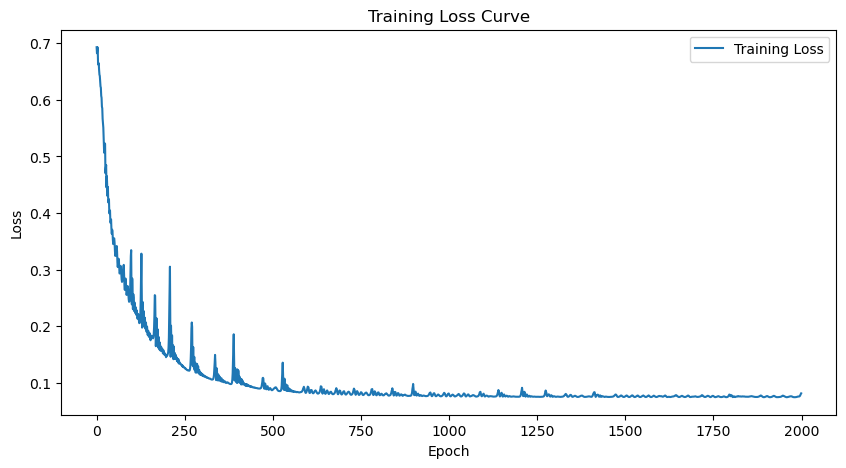

Final Model Accuracy: 83.68%
Final Model F1-score: 0.8510


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_4_layer.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.94      0.73      0.82       194
non_infringement       0.77      0.95      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



/tmp/ipykernel_3895896/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
